Steps to Run Fpocket
1. Ctrl + Shift + Run Task
2. Run FPocket
3. Enter Name of enzyme anf file location

In [ ]:
# Imports
import re
import os
import pandas as pd
from collections import namedtuple

In [69]:
# Step 1: Parse the pocket summary file and rank pockets
def parse_and_rank_pockets(summary_file, top_n=5):
    Pocket = namedtuple('Pocket', ['id', 'score', 'druggability', 'volume'])
    pockets = []
    with open(summary_file, 'r') as f:
        content = f.read()
    # Find each pocket's block
    pocket_blocks = re.split(r'(?=Pocket \d+)', content)
    for block in pocket_blocks:
        m_id = re.search(r'Pocket (\d+)', block)
        m_score = re.search(r'Score\s*:\s*([\d\.]+)', block)
        m_drug = re.search(r'Druggability Score\s*:\s*([\d\.]+)', block)
        m_vol = re.search(r'Volume\s*:\s*([\d\.]+)', block)
        if m_id and m_score:
            pockets.append(
                Pocket(
                    id=int(m_id.group(1)),
                    score=float(m_score.group(1)),
                    druggability=float(m_drug.group(1)) if m_drug else None,
                    volume=float(m_vol.group(1)) if m_vol else None
                )
            )

    # Sort pockets on these factors in this order (score > druggability > volume)
    pockets = sorted(pockets, key=lambda x: (-x.score, -x.druggability if x.druggability else 0, -x.volume if x.volume else 0))
    return pockets[:top_n]

In [70]:
# Main execution block
if __name__ == "__main__":
    # Set paths
    base_dir = r"c:\Users\mohak\Downloads\AlphaFold\databank\transthyretin_f2c07\cif\5mut\5mut_out"
    summary_file = os.path.join(base_dir, "5mut_info.txt")
    # Step 1: Parse and rank pockets
    print("=== Ranking Pockets ===")
    ranked_pockets = parse_and_rank_pockets(summary_file, top_n=50)
    # print(ranked_pockets)
    
    # Create a DataFrame for better visualization
    pocket_data = []
    for pocket in ranked_pockets:
        pocket_data.append({
            'Pocket ID': pocket.id,
            'Score': pocket.score,
            'Druggability': pocket.druggability,
            'Volume': pocket.volume
        })
    # print(pocket_data)
    pocket_df = pd.DataFrame(pocket_data)
    print(pocket_df)

=== Ranking Pockets ===
    Pocket ID  Score  Druggability    Volume
0           1  1.623         1.000  2103.820
1           2  0.084         0.000   306.999
2           3  0.080         0.011   663.963
3           4  0.045         0.000   297.189
4           5  0.039         0.001   417.687
5           6  0.031         0.000   264.644
6           7  0.022         0.000   164.775
7           8  0.016         0.005   452.919
8           9  0.016         0.000   335.539
9          10  0.009         0.000   328.275
10         13  0.005         0.005   311.074
11         15  0.004         0.004   441.821
12         11  0.003         0.000   393.388
13         16  0.002         0.002   296.692
14         20  0.002         0.002   288.395
15         21  0.001         0.001   571.360
16         18  0.001         0.001   426.960
17         22  0.001         0.001   379.451
18         17  0.001         0.001   205.982
19         19  0.000         0.000   281.882
20         12  0.000         0.

In [71]:
# Step 2: Extract unique residue info from pocket files
# Assumes .pqr files named 'pocket<ID>.pqr' in same dir

def extract_pocket_residues(pocket_ids, base_dir):
    residue_set = dict()
    for pid in pocket_ids:
        # Look for pocket<ID>_vert.pqr files in the pockets directory
        pqr_file = os.path.join(base_dir, "pockets", f"pocket{pid}_vert.pqr")
        
        # Also look for corresponding pocket<ID>_atm.cif files which contain residue information
        cif_file = os.path.join(base_dir, "pockets", f"pocket{pid}_atm.cif")
        
        residues = set()
        
        # First try to extract from CIF file which has more detailed residue information
        if os.path.exists(cif_file):
            with open(cif_file, 'r') as f:
                atom_section = False
                for line in f:
                    if line.startswith(('ATOM', 'HETATM')):
                        parts = line.split()
                        if len(parts) >= 15:  # CIF format has more columns
                            res_name = parts[5]
                            chain = parts[6]
                            res_num = parts[7]
                            residues.add(f"{res_name} {chain} {res_num}")

        residue_set[pid] = sorted(list(residues))
    return residue_set


# Step 2: Extract residues from top pockets
print("\n=== Extracting Residues from Top Pockets ===")
pocket_ids = [p.id for p in ranked_pockets]
residue_info = extract_pocket_residues(pocket_ids, base_dir)

# Display residue information for each pocket
for pid in pocket_ids:
    print(f"\nPocket {pid} Residues:")
    if residue_info[pid]:
        for residue in residue_info[pid]:
            print(f"  {residue}")
    else:
        print("No residue information found")


=== Extracting Residues from Top Pockets ===

Pocket 1 Residues:
  ALA A 226
  ALA A 24
  ALA A 28
  ALA A 327
  ALA A 64
  ALA A 65
  ARG A 105
  ARG A 115
  ASN A 114
  ASN A 150
  ASN A 181
  ASN A 253
  ASN A 98
  ASP A 228
  GLN A 110
  GLN A 16
  GLY A 117
  GLY A 271
  GLY A 272
  GLY A 275
  GLY A 303
  GLY A 304
  GLY A 332
  GLY A 66
  HIS A 25
  LEU A 11
  LEU A 15
  LEU A 19
  LEU A 27
  LEU A 278
  LEU A 324
  LEU A 328
  LEU A 36
  LEU A 37
  LYS A 224
  LYS A 276
  LYS A 69
  MET A 12
  MET A 80
  PHE A 118
  PHE A 31
  PHE A 330
  PHE A 67
  PRO A 21
  PRO A 333
  PRO A 38
  SER A 274
  SER A 306
  SER A 89
  THR A 252
  THR A 254
  THR A 32
  THR A 326
  THR A 329
  TRP A 331
  TYR A 116
  TYR A 325
  TYR A 7
  VAL A 103
  VAL A 112
  VAL A 182
  VAL A 256
  VAL A 302
  VAL A 305

Pocket 2 Residues:
  ALA A 265
  ARG A 115
  GLU A 269
  LEU A 266
  SER A 268
  THR A 270

Pocket 3 Residues:
  ALA A 260
  ARG A 279
  ASP A 109
  ASP A 280
  GLN A 110
  GLN A 284
  GLU A

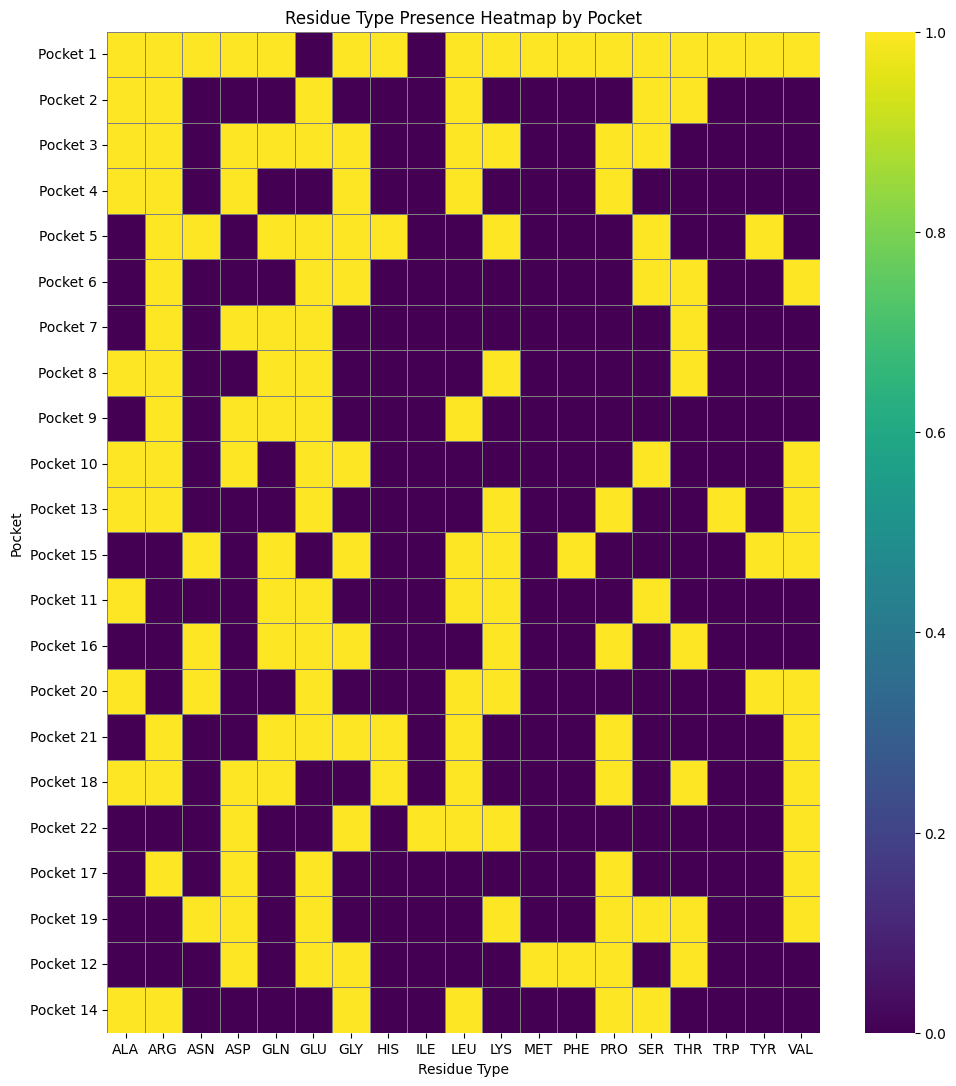

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# residue_info: dict {pocket_id: [residue_strs]}, e.g. 'ARG A 135'

# Extract residue types by pocket
pocket_residue_types = {pid: [r.split()[0] for r in residues] for pid, residues in residue_info.items()}

# Tabulate unique residue types
all_res_types = sorted({res for res_list in pocket_residue_types.values() for res in res_list})

# Create presence/absence DataFrame
data = []
for pid in pocket_ids:
    row = [1 if res in pocket_residue_types[pid] else 0 for res in all_res_types]
    data.append(row)
df = pd.DataFrame(data, index=[f'Pocket {pid}' for pid in pocket_ids], columns=all_res_types)

# Plot heatmap
plt.figure(figsize=(len(all_res_types)*0.5+2, len(pocket_ids)*0.5+2))
sns.heatmap(df, cmap='viridis', cbar=True, linewidths=0.5, linecolor='gray')
plt.title('Residue Type Presence Heatmap by Pocket')
plt.ylabel('Pocket')
plt.xlabel('Residue Type')
plt.show()


In [ ]:
# import numpy as np
# from sklearn.cluster import DBSCAN, AgglomerativeClustering
# from scipy.spatial.distance import pdist, squareform
# import matplotlib.pyplot as plt
# import seaborn as sns

# def extract_residue_coordinates(pocket_ids, base_dir):
#     residue_coords = {}
#     for pid in pocket_ids:
#         cif_file = os.path.join(base_dir, "pockets", f"pocket{pid}_atm.cif")
#         residues = {}
        
#         if os.path.exists(cif_file):
#             with open(cif_file, 'r') as f:
#                 for line in f:
#                     if line.startswith(('ATOM', 'HETATM')):
#                         parts = line.split()
#                         if len(parts) >= 15:
#                             res`  _id = f"{parts[5]} {parts[6]} {parts[7]}"
#                             x, y, z = float(parts[10]), float(parts[11]), float(parts[12])
                            
#                             if res_id not in residues:
#                                 residues[res_id] = []
#                             residues[res_id].append([x, y, z])
        
#         # Calculate centroid for each residue
#         centroids = {}
#         for res_id, coords in residues.items():
#             centroids[res_id] = np.mean(coords, axis=0)
        
#         residue_coords[pid] = centroids
    
#     return residue_coords

# def spatial_cluster_residues(residue_coords, eps=8.0, min_samples=3):
#     """Cluster residues based on spatial proximity"""
#     clustered_pockets = {}
    
#     for pid, coords in residue_coords.items():
#         if not coords:
#             continue
            
#         residue_names = list(coords.keys())
#         positions = np.array(list(coords.values()))
        
#         # Perform DBSCAN clustering
#         clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(positions)
        
#         # Group residues by cluster
#         clusters = {}
#         for i, cluster_id in enumerate(clustering.labels_):
#             if cluster_id not in clusters:
#                 clusters[cluster_id] = []
#             clusters[cluster_id].append(residue_names[i])
        
#         clustered_pockets[pid] = clusters
    
#     return clustered_pockets

# # Usage:
# coords = extract_residue_coordinates(pocket_ids, base_dir)
# clusters = spatial_cluster_residues(coords)

# # Create clustered heatmap
# def create_spatial_heatmap(clusters):
#     all_residues = []
#     pocket_cluster_data = []
    
#     for pid, pocket_clusters in clusters.items():
#         for cluster_id, residues in pocket_clusters.items():
#             if cluster_id != -1:  # Exclude noise points
#                 cluster_name = f"P{pid}_C{cluster_id}"
#                 res_types = [r.split()[0] for r in residues]
#                 all_residues.extend(res_types)
#                 pocket_cluster_data.append((cluster_name, res_types))
    
#     unique_res_types = sorted(set(all_residues))
    
#     # Create presence matrix
#     data = []
#     labels = []
#     for cluster_name, res_types in pocket_cluster_data:
#         row = [res_types.count(res) for res in unique_res_types]
#         data.append(row)
#         labels.append(cluster_name)
    
#     df = pd.DataFrame(data, index=labels, columns=unique_res_types)
    
#     plt.figure(figsize=(15, 8))
#     sns.heatmap(df, cmap='viridis', cbar=True, annot=True, fmt='d')
#     plt.title('Spatial Clusters of Residues in Binding Pockets')
#     plt.ylabel('Pocket Clusters')
#     plt.xlabel('Residue Type Count')
#     plt.show()
    
#     return df

Total residues extracted: 250
Unique residues: 192
Consensus residues (≥3 pockets): 7
Total clusters: 38
Major clusters (≥10 residues): 5


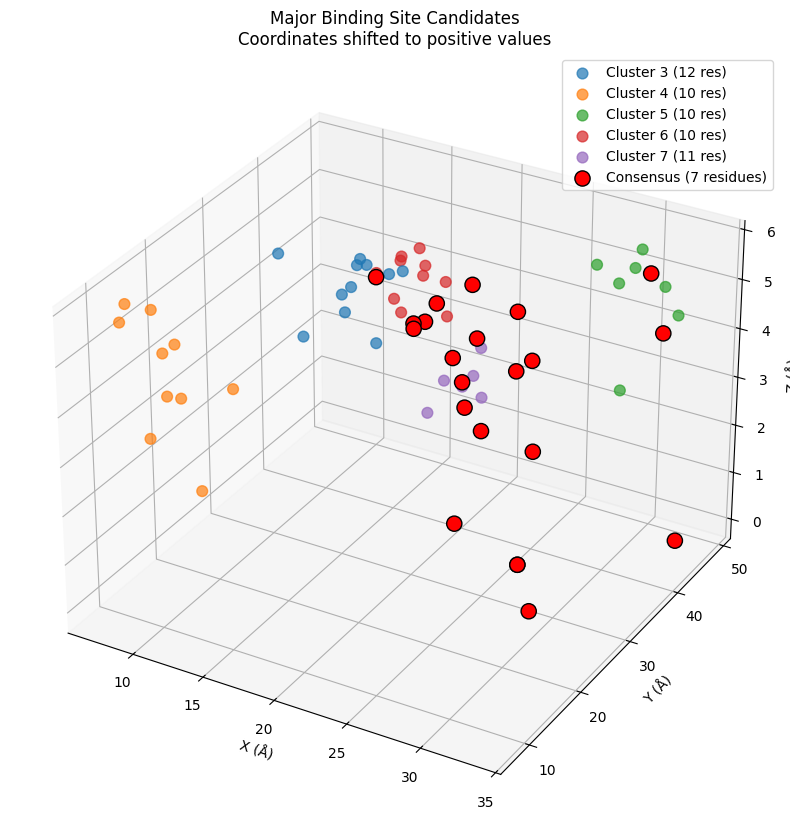

In [74]:
import os
import numpy as np
from collections import defaultdict
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

def analyze_binding_sites(pocket_ids, base_dir, consensus_threshold=3, distance_threshold=10.0):
    # Step 1: Extract residue centroids from all pockets
    residue_coords = dict()
    res_pocket_map = defaultdict(set)  # residue_str -> set of pockets
    all_residues = []
    all_coords = []

    for pid in pocket_ids:
        cif_file = os.path.join(base_dir, "pockets", f"pocket{pid}_atm.cif")
        residues = defaultdict(list)
        if os.path.exists(cif_file):
            with open(cif_file, 'r') as f:
                for line in f:
                    if line.startswith(('ATOM', 'HETATM')):
                        parts = line.split()
                        if len(parts) >= 15:
                            res_name = parts[5]
                            chain = parts[6]
                            res_num = parts[7]
                            x, y, z = float(parts[10]), float(parts[11]), float(parts[12])
                            res_id = f"{res_name} {chain} {res_num}"
                            residues[res_id].append([x, y, z])
        # Calculate centroid for each residue in this pocket
        centroid_dict = {}
        for res_id, coords in residues.items():
            centroid = np.mean(coords, axis=0)
            centroid_dict[res_id] = centroid
            all_residues.append(res_id)
            all_coords.append(centroid)
            res_pocket_map[res_id].add(pid)
        residue_coords[pid] = centroid_dict

    all_coords = np.array(all_coords)
    
    # Shift coordinates to all positive values
    shifted_coords = all_coords - all_coords.min(axis=0)

    # Step 2: Determine consensus residues (appear in >= consensus_threshold pockets)
    consensus_residues = {res for res, ps in res_pocket_map.items() if len(ps) >= consensus_threshold}
    consensus_idx = [i for i, res in enumerate(all_residues) if res in consensus_residues]

    # Print statistics
    print(f"Total residues extracted: {len(all_residues)}")
    print(f"Unique residues: {len(set(all_residues))}")
    print(f"Consensus residues (≥{consensus_threshold} pockets): {len(consensus_residues)}")
    
    # Step 3: Global spatial clustering on shifted coordinates
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=distance_threshold)
    labels = clustering.fit_predict(shifted_coords)
    
    # Analyze cluster sizes
    cluster_sizes = {cl: np.sum(labels == cl) for cl in np.unique(labels)}
    major_clusters = {cl: size for cl, size in cluster_sizes.items() if size >= 10}  # Clusters with ≥10 residues
    
    print(f"Total clusters: {len(cluster_sizes)}")
    print(f"Major clusters (≥10 residues): {len(major_clusters)}")
    
    # Step 4: Plot only major clusters for clarity
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    for cl in major_clusters.keys():
        idx = np.where(labels == cl)[0]
        ax.scatter(shifted_coords[idx,0], shifted_coords[idx,1], shifted_coords[idx,2], 
                  label=f'Cluster {cl} ({cluster_sizes[cl]} res)', s=60, alpha=0.7)
    
    # Highlight consensus residues
    if consensus_idx:
        ax.scatter(shifted_coords[consensus_idx,0], shifted_coords[consensus_idx,1], shifted_coords[consensus_idx,2],
                   color='red', s=120, edgecolor='black', 
                   label=f'Consensus ({len(consensus_residues)} residues)', alpha=1.0)
    
    ax.set_title('Major Binding Site Candidates\nCoordinates shifted to positive values')
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    
    ax.legend()
    plt.show()
    
    return major_clusters, consensus_residues

# Usage
major_clusters, consensus_residues = analyze_binding_sites(pocket_ids, base_dir)


- We use AgglomerativeClustering with the parameter distance_threshold=10.0 and n_clusters=None — this means clusters are formed by merging data points (residue centroids) that are within a certain spatial distance of each other. Major clusters are plotted, whcih have more than 10 residues within the distance threshold.

- Consensus residues are calculated by counting, across all extracted residues, how many different pockets each residue is part of. Only residues participating in 3 or more pockets are counted as "consensus".

- Each occurrence of a consensus residue in each pocket is shown as a separate point in the plot.

- If the same consensus residue appears in multiple pockets, its centroid gets calculated for each pocket, which may differ slightly due to structure/atom variation or alignment between pockets.

- These red-highlighted points represent each time a consensus residue is included in a pocket and indicate where important functional surfaces likely cluster in 3D space.